# whole genome $F_{ST}$ and $\pi$

Heavily uses scikit-allel: https://scikit-allel.readthedocs.io/en/stable/

The primary input data is a vartiant call file (vcf) converted to a `zarr` archive using the `vcf2zarr.py` script.  
Loading the archive and primary filtering is done with the `allel_helpers.LoadRegion(...)` function in `allel_helpers.py`.  
From that point, it is all fairly simple.

In [1]:
import sys; print(sys.version)
import os
import glob
import subprocess
import multiprocessing
import functools
from collections import OrderedDict
import timeit

import numpy as np; print('numpy', np.__version__)
import matplotlib as mpl; print('matplotlib', mpl.__version__)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd; print('pandas',pd.__version__)
import allel; print('allel', allel.__version__)
import zarr; print('zarr', zarr.__version__)

# sys.path.append('/home/travc/git/ngs_scripts/ngs_py_utils/') # use if custom module files are stored elsewhere
import allel_helpers; print('allel_helpers', allel_helpers.__version__)

from IPython.display import display, HTML

3.6.7 | packaged by conda-forge | (default, Jul  2 2019, 02:18:42) 
[GCC 7.3.0]
numpy 1.17.0
matplotlib 3.1.1
pandas 0.25.0
allel 1.2.1
zarr 2.3.2
allel_helpers 0.2.0


In [2]:
%matplotlib notebook
mpl.rcParams['figure.facecolor'] = '#BBBBBB'

## Inputs / Constants

In [1]:
META_FN = 'sample_meta.csv'
INFN_ZARR = '/data/vcfs/YL-Agam-GF2_pflit.vcf.gz.zarr'

SAVE = True # save results to files (filenames hardcoded below)

CHROMS = ['2R','2L','3R','3L','X']
CHROM_SIZE = { # for AgamP4, taken from the `.fai` index file
    '2L': 49364325,
    '3L': 41963435,
    'X':  24393108,
    '3R': 53200684,
    '2R': 61545105,
    'UNKN': 42389979,
    'Y_unplaced': 237045,
    'Mt': 15363 }

ADD_REFERENCE = False # optionally include the reference as a virtual sample

GROUP_COL = 'group' # the column heading in meta used to determine groups

FILTER_SNP = True # only keep SNPs
FILTER_BIALLELIC = True # only keep biallelic loci
FILTER_SINGLETON = True # also filters biallelic
MIN_FMTDP = 6 # individual calls with a depth < MIN_FMTDP are recoded as '.' (no call)
MAX_MISSING_PROPORTION = 0.20 # remove loci where > this fraction of samples are unclalled; applied for set of all samples in meta
GROUP_MAX_MISSING_PROPORTION = None # optional per-group max_missing

## Open the variant callset and parse metadata

In [4]:
callset = zarr.open_group(INFN_ZARR, mode='r')
meta_in = pd.read_csv(META_FN, index_col=0)

In [5]:
meta_in

,group,lat,lng,NCBI accession number,# raw reads,% mapped reads,Medium insert size,coverage
sample,,,,,,,,
06SAMA0103,SAMA,13.91670,-8.08330,pending,22045130,97.78%,429,8.0
06SAMA0130,SAMA,13.91670,-8.08330,pending,23756245,98.07%,427,8.6
06FOUN0009,FOUN,12.89163,-9.46063,pending,42565747,94.19%,407,14.8
06FOUN0010,FOUN,12.89163,-9.46063,pending,56097824,90.67%,368,18.8
06FOUN0026,FOUN,12.89163,-9.46063,pending,25316623,90.22%,405,8.5
06FOUN0028,FOUN,12.89163,-9.46063,pending,20774239,93.10%,400,7.2
06DONE0022,DONE,12.80683,-7.98476,pending,22844443,95.41%,401,8.1
06DONE0044,DONE,12.80683,-7.98476,pending,52238457,89.33%,393,17.3
06DONE0045,DONE,12.80683,-7.98476,pending,50681550,92.93%,380,17.4


In [6]:
groups = meta_in['group'].unique()
groups

array(['SAMA', 'FOUN', 'DONE', 'BANA', 'NGAB', 'SENO', 'FARA', 'KELA',
       'SEL', 'FOUM', 'TNZK', 'NCHE', 'BOU', 'BOE', 'OSS', 'MUT', 'SAL',
       'MAL', 'MIR', 'WAN', 'ASS', 'MOY'], dtype=object)

## Load the genotype arrays

In [7]:
g_dict = OrderedDict()
pos_dict = OrderedDict()
meta = None
for ch in CHROMS:
    print("Chrom:", ch)
    g_dict[ch],pos_dict[ch],meta_out = allel_helpers.LoadRegion(
                callset, meta_in, ch,
                min_FMTDP=MIN_FMTDP,
                filter_snp=FILTER_SNP,
                filter_biallelic=FILTER_BIALLELIC,
                max_missing_proportion=MAX_MISSING_PROPORTION,
                group_col=GROUP_COL,
                group_max_missing_proportion=GROUP_MAX_MISSING_PROPORTION)

    if meta is None:
        meta = meta_out
    else:
        # ensure meta hasn't changed (it should be the same for all chroms)
        assert meta.equals(meta_out)
        
# make a copy of meta so we don't have to worry about reusing the name
g_dict_meta = meta.copy(deep=True)

Chrom: 2R
Region: 2R -> ('2R', 1, None)
total number of loci = 8181179
461704846 genotype calls of 908110869 (50.84%) fail FMT:DP filter
= 7203354 passing previous filters & SNP
= 5006562 passing previous filters & biallelic
max missing proportion 0.2 of 111 is 22
max missing passing loci = 3305898 (40.41%)
= 3212226 passing previous filters & max_missing
Passing all all filters 3212226 of 8181179 (39.26%)
Chrom: 2L
Region: 2L -> ('2L', 1, None)
total number of loci = 7410461
431127502 genotype calls of 822561171 (52.41%) fail FMT:DP filter
= 6499780 passing previous filters & SNP
= 4371743 passing previous filters & biallelic
max missing proportion 0.2 of 111 is 22
max missing passing loci = 2833149 (38.23%)
= 2756465 passing previous filters & max_missing
Passing all all filters 2756465 of 7410461 (37.20%)
Chrom: 3R
Region: 3R -> ('3R', 1, None)
total number of loci = 8132982
475714065 genotype calls of 902761002 (52.70%) fail FMT:DP filter
= 7196383 passing previous filters & SNP
= 

In [8]:
print("Total loci passing all filters", sum([_.shape[0] for _ in g_dict.values()]))

Total loci passing all filters 11944447


## $F_{ST}$ Calculation

In [9]:
# start with clean version of the genotype array and meta based on g_dict
# combine GenotypeArrays into a single one
g = g_dict[list(g_dict.keys())[0]].concatenate([g_dict[ch] for ch in list(g_dict.keys())[1:]])
# copy the meta
meta = g_dict_meta.copy(deep=True)

In [10]:
meta

,group,lat,lng,NCBI accession number,# raw reads,% mapped reads,Medium insert size,coverage,callset_idx,idx
sample,,,,,,,,,,
06SAMA0103,SAMA,13.91670,-8.08330,pending,22045130,97.78%,429,8.0,35,0
06SAMA0130,SAMA,13.91670,-8.08330,pending,23756245,98.07%,427,8.6,36,1
06FOUN0009,FOUN,12.89163,-9.46063,pending,42565747,94.19%,407,14.8,25,2
06FOUN0010,FOUN,12.89163,-9.46063,pending,56097824,90.67%,368,18.8,26,3
06FOUN0026,FOUN,12.89163,-9.46063,pending,25316623,90.22%,405,8.5,27,4
06FOUN0028,FOUN,12.89163,-9.46063,pending,20774239,93.10%,400,7.2,28,5
06DONE0022,DONE,12.80683,-7.98476,pending,22844443,95.41%,401,8.1,6,6
06DONE0044,DONE,12.80683,-7.98476,pending,52238457,89.33%,393,17.3,7,7
06DONE0045,DONE,12.80683,-7.98476,pending,50681550,92.93%,380,17.4,8,8


### By group pairwise Fst

In [11]:
group_col = 'group'

all_groups = meta[group_col].unique()

hfst_df = pd.DataFrame(index=all_groups, columns=all_groups)
hfst_se_df = pd.DataFrame(index=all_groups, columns=all_groups)

for i1 in range(len(all_groups)):
    grp1 = all_groups[i1]
    g1 = g[:,meta[meta[group_col]==grp1]['idx']]
    ac1 = g1.count_alleles()

    for i2 in range(i1):
        grp2 = all_groups[i2]
        print(group_col, ':', grp1, 'v', grp2)

        g2 = g[:,meta[meta[group_col]==grp2]['idx']]
        ac2 = g2.count_alleles()
        
        hfst,hfst_se,_,_ = allel.average_hudson_fst(ac1, ac2, blen=1000)
        hfst_df.loc[grp1,grp2] = hfst
        hfst_se_df.loc[grp1,grp2] = hfst_se
        
        # fill in symmetric values
        hfst_df.loc[grp2,grp1] = hfst
        hfst_se_df.loc[grp2,grp1] = hfst_se

#         if i2 > 1: break  # @TCC testing shortcut
#     if i1 > 1: break  # @TCC testing shortcut
hfst_df

group : FOUN v SAMA
group : DONE v SAMA
group : DONE v FOUN
group : BANA v SAMA
group : BANA v FOUN
group : BANA v DONE
group : NGAB v SAMA
group : NGAB v FOUN
group : NGAB v DONE
group : NGAB v BANA
group : SENO v SAMA
group : SENO v FOUN
group : SENO v DONE
group : SENO v BANA
group : SENO v NGAB
group : FARA v SAMA
group : FARA v FOUN
group : FARA v DONE
group : FARA v BANA
group : FARA v NGAB
group : FARA v SENO
group : KELA v SAMA
group : KELA v FOUN
group : KELA v DONE
group : KELA v BANA
group : KELA v NGAB
group : KELA v SENO
group : KELA v FARA
group : SEL v SAMA
group : SEL v FOUN
group : SEL v DONE
group : SEL v BANA
group : SEL v NGAB
group : SEL v SENO
group : SEL v FARA
group : SEL v KELA
group : FOUM v SAMA
group : FOUM v FOUN
group : FOUM v DONE
group : FOUM v BANA
group : FOUM v NGAB
group : FOUM v SENO
group : FOUM v FARA
group : FOUM v KELA
group : FOUM v SEL
group : TNZK v SAMA
group : TNZK v FOUN
group : TNZK v DONE
group : TNZK v BANA
group : TNZK v NGAB
group : T

,SAMA,FOUN,DONE,BANA,NGAB,SENO,FARA,KELA,SEL,FOUM,...,BOU,BOE,OSS,MUT,SAL,MAL,MIR,WAN,ASS,MOY
SAMA,NaN,-0.0186445,-0.0209826,-0.0130568,-0.00317821,-0.0159038,-0.0289905,-0.0157818,-0.0193487,0.0231173,...,0.149853,0.14055,0.137537,0.147341,0.151566,0.141575,0.166105,0.156397,0.176582,0.180735
FOUN,-0.0186445,NaN,-0.004837,-0.00412334,0.0246633,-0.0076963,0.00548608,-0.0105506,-0.0087885,0.0309915,...,0.166463,0.158145,0.155959,0.162618,0.169367,0.156118,0.178723,0.168128,0.184873,0.190452
DONE,-0.0209826,-0.004837,NaN,-0.00295593,0.00694909,-0.00202304,-0.00164884,-0.00260888,-0.0070878,0.0293289,...,0.168215,0.160962,0.158957,0.163938,0.171679,0.157469,0.180708,0.170735,0.193175,0.196319
BANA,-0.0130568,-0.00412334,-0.00295593,NaN,0.0270852,-0.00190884,0.0093911,-0.00392823,-0.00435767,0.017975,...,0.157596,0.15391,0.152465,0.152115,0.162764,0.14546,0.165963,0.156806,0.178498,0.181163
NGAB,-0.00317821,0.0246633,0.00694909,0.0270852,NaN,0.022663,0.0112465,0.0261233,0.0198673,0.0732236,...,0.213444,0.203475,0.200836,0.210222,0.215616,0.203513,0.22928,0.219182,0.241324,0.245457
SENO,-0.0159038,-0.0076963,-0.00202304,-0.00190884,0.022663,NaN,0.0058753,-0.0066648,-0.00787074,0.0308541,...,0.170575,0.16364,0.16134,0.167048,0.174563,0.160596,0.185861,0.17524,0.199496,0.202302
FARA,-0.0289905,0.00548608,-0.00164884,0.0093911,0.0112465,0.0058753,NaN,0.00681543,-0.000826359,0.0421594,...,0.1766,0.167123,0.164429,0.17379,0.178761,0.167681,0.192394,0.182546,0.203543,0.207497
KELA,-0.0157818,-0.0105506,-0.00260888,-0.00392823,0.0261233,-0.0066648,0.00681543,NaN,-0.00796727,0.0321191,...,0.17321,0.165403,0.163075,0.169201,0.176327,0.162597,0.186287,0.175763,0.195936,0.200539
SEL,-0.0193487,-0.0087885,-0.0070878,-0.00435767,0.0198673,-0.00787074,-0.000826359,-0.00796727,NaN,0.0229286,...,0.161948,0.154096,0.15186,0.158231,0.165082,0.151367,0.175369,0.165059,0.187129,0.190534
FOUM,0.0231173,0.0309915,0.0293289,0.017975,0.0732236,0.0308541,0.0421594,0.0321191,0.0229286,NaN,...,0.159429,0.159902,0.159563,0.151612,0.166568,0.144262,0.162925,0.154983,0.183227,0.181539


In [12]:
hfst_df.to_csv('hfst_by_{}.csv'.format(group_col))
hfst_se_df.to_csv('hfst_se_by_{}.csv'.format(group_col))

## Sequence Diversity ($\pi$)

In [13]:
group_col = 'group'

meta = g_dict_meta.copy(deep=True) # copy metadata for safety 

all_groups = meta[group_col].unique()

pi_df = pd.DataFrame(index=all_groups, columns=[*CHROMS, 'overall'])

for i1 in range(len(all_groups)):
    grp1 = all_groups[i1]
    w_pi_sum = 0 
    w_sum = 0
    
    for ch in CHROMS:
        g1 = g_dict[ch][:,meta[meta[group_col]==grp1]['idx']]
        ac1 = g1.count_alleles()

        pi = allel.sequence_diversity(pos_dict[ch], ac1)
        pi_df.loc[grp1,ch] = pi
        
        w_sum += CHROM_SIZE[ch]
        w_pi_sum += pi*CHROM_SIZE[ch]
        
        print(grp1, ch, pi)
    pi_df.loc[grp1,'overall'] = w_pi_sum/w_sum
pi_df

SAMA 2R 0.006672578582372447
SAMA 2L 0.006474646207680008
SAMA 3R 0.007116275764186594
SAMA 3L 0.0065144935958240035
SAMA X 0.005372669111445268
FOUN 2R 0.005897218708866781
FOUN 2L 0.0062012497271691155
FOUN 3R 0.006233943391580861
FOUN 3L 0.005764068766249281
FOUN X 0.0029989104025355197
DONE 2R 0.006250100511025607
DONE 2L 0.006523701436403925
DONE 3R 0.0065057574378460945
DONE 3L 0.005945576423045931
DONE X 0.003161537774647545
BANA 2R 0.006230434522662435
BANA 2L 0.0068620124826832005
BANA 3R 0.0064674598442050835
BANA 3L 0.00595754263105578
BANA X 0.003543491032304292
NGAB 2R 0.005015146068054734
NGAB 2L 0.005572660201444813
NGAB 3R 0.006122727731063244
NGAB 3L 0.005605023781297143
NGAB X 0.002855826887240122
SENO 2R 0.0060294645068331475
SENO 2L 0.006156963611631234
SENO 3R 0.006275219911341218
SENO 3L 0.005762749373923319
SENO X 0.0030067416597159098
FARA 2R 0.006441529792496501
FARA 2L 0.006219768002083238
FARA 3R 0.006751323190147948
FARA 3L 0.006198333235885411
FARA X 0.0041

,2R,2L,3R,3L,X,overall
SAMA,0.00667258,0.00647465,0.00711628,0.00651449,0.00537267,0.00656624
FOUN,0.00589722,0.00620125,0.00623394,0.00576407,0.00299891,0.00570906
DONE,0.0062501,0.0065237,0.00650576,0.00594558,0.00316154,0.00598537
BANA,0.00623043,0.00686201,0.00646746,0.00595754,0.00354349,0.00608635
NGAB,0.00501515,0.00557266,0.00612273,0.00560502,0.00285583,0.00526909
SENO,0.00602946,0.00615696,0.00627522,0.00576275,0.00300674,0.00574501
FARA,0.00644153,0.00621977,0.00675132,0.00619833,0.00414651,0.00617835
KELA,0.00584977,0.00609691,0.00616334,0.00568594,0.00289174,0.00563218
SEL,0.00635225,0.00649723,0.00654797,0.00601339,0.00313501,0.00602627
FOUM,0.00629546,0.00687171,0.0068312,0.00629227,0.00317173,0.00621136


In [14]:
pi_df.to_csv('pi_by_{}.csv'.format(group_col))

### plot of $\pi$ by group

<IPython.core.display.Javascript object>


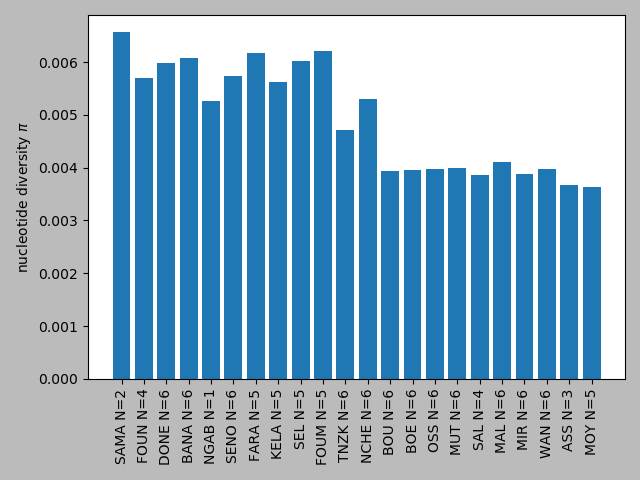

In [15]:
fig,ax = mpl.pyplot.subplots()
labels = pi_df.index.str.cat(meta[group_col].value_counts()[pi_df.index].astype(str), sep=' N=')
ax.bar(x=np.arange(pi_df.shape[0]), height=pi_df['overall'], tick_label=labels)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('nucleotide diversity $\pi$')
fig.tight_layout()